# **Binary Prediction of Smoker Status using Bio-Signals**

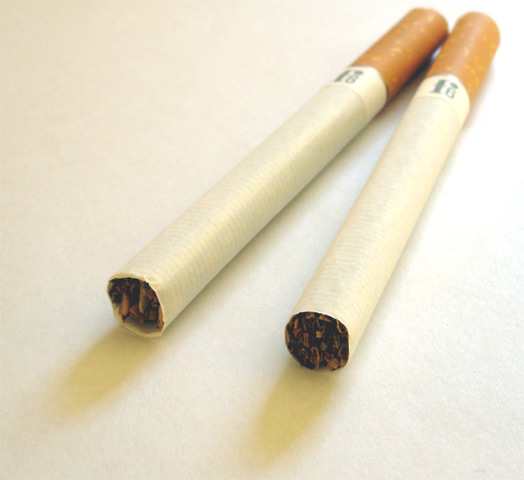

# Introduction

Welcome to the 2023 Kaggle Playground Series! In this exciting competition, participants are tasked with leveraging binary classification to predict a patient's smoking status based on diverse health indicators. The dataset, derived from a deep learning model trained on the Smoker Status Prediction using Bio-Signals dataset, closely mirrors the original feature distributions. However, participants are encouraged to explore potential differences and evaluate whether incorporating the original dataset enhances model performance. The competition involves analyzing the provided train and test datasets, with submissions evaluated on the area under the ROC curve between predicted probabilities and observed targets. Best of luck to all participants in this intriguing challenge!

# Solution Approach

1. Classify the data into numerical and categorical categories and perform data cleaning to ensure completeness.
2. Utilize domain knowledge in the biomedical field to conduct feature engineering and incorporate additional features into the existing dataset. Reference the following notebook for domain knowledge: [Biomedical Knowledge Notebook](https://www.kaggle.com/competitions/playground-series-s3e24/discussion/450314).
3. Apply one-hot encoding to categorical features and employ XGBoost, CatBoost, LightGBM, NN, and a Voting Model to model the data and make predictions.
4. Compare results across different models to identify the optimal solution for decision-making.

In [1]:
import numpy as np 
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay


# Some useful functions

In [2]:
def summary(df):
    sum = pd.DataFrame(df.dtypes, columns=['dtypes'])
    sum['missing#'] = df.isna().sum()
    sum['missing%'] = (df.isna().sum()/len(df))
    sum['uniques'] = df.nunique().values
    sum['count'] = df.count().values

    return sum

In [3]:
def chi_squared_test(df, input_var, target_var, significance_level=0.05):
    contingency_table = pd.crosstab(df[input_var], df[target_var])
    chi2, p, _ , _= stats.chi2_contingency(contingency_table)

    if p < significance_level:
        print(f'{input_var} has a significant relationship with the target.')
    else:
        print(f'{input_var} does not have a significant relationship with the target.')


In [4]:
def classify_bmi(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif 18.5 <= bmi < 25:
        return 'Normal'
    elif 25 <= bmi < 30:
        return 'Overweight'
    elif 30 <= bmi < 35:
        return 'Obese-grade 1'
    elif 35 <= bmi < 40:
        return 'Obese-grade 2'
    else:
        return 'Obese-grade 3'


def classify_age(age):
    if age < 45:
        return 'lower_risk'
    else:
        return 'high_risk'
    

def classify_blood_pressure(systolic, diastolic):
    if (systolic < 120) or (diastolic<80):
        return 'normal'
    elif ((systolic>=120) and (systolic<129)) or ((diastolic>=80) and (diastolic<89)):
        return 'elevated'
    elif ((systolic>=130) and (systolic<139)) or ((diastolic>=90) and (diastolic<99)):
        return 'stage_1_high_BP'
    elif ((systolic>=140) and (systolic<179)) or ((diastolic>=100) and (diastolic<119)):
        return 'stage_2_high_BP'
    else:
        return 'emergency'

def classify_total_HDL_LDL(HDL,LDL):
    tot = HDL + LDL
    if tot < 200:
        return 'Desirable'
    elif (tot>=200) and (tot<=239):
        return 'Borderline_high'
    else:
        return 'High'

def classify_HDL(HDL):
    if HDL<40:
        return 'High_risk'
    elif (HDL>=40) and (HDL<60):
        return 'Normal'
    else:
        return 'Low_risk'

    
def classify_LDL(LDL):
    if LDL<100:
        return 'Optimal'
    elif (LDL>=100) and (LDL<=129):
        return 'Near_optimal'
    elif (LDL>=130) and (LDL<=159):
        return 'Borderline_high'
    elif (LDL>=160) and (LDL<=189):
        return 'High'
    else:
        return 'Very_High'

def classify_triglyceride(triglyceride):
    if triglyceride<150:
        return 'normal'
    elif (triglyceride>=150) and (triglyceride<=199):
        return 'moderate_risk'
    elif (triglyceride>=200) and (triglyceride<=499):
        return 'high_risk'
    else:
        return 'very_high_risk'


def classify_hemoglobin(hemoglobin):
    """
    Haemoglobin classification for anemic cases:

    Children aged under 5 years and pregnant women <110 g/L - high risk for anemic case
    Others- <120 g/L - high risk for anemic case
    
    But, here I only use the standard "<120 g/L".
    """
    if hemoglobin<12:
        return 'anemia'
    else:
        return 'normal'

def classify_serum_creatinine(serum_creatinine):
    if (serum_creatinine >= (0.74+0.59)/2) and (serum_creatinine <= (1.35+1.04)/2):
        return 'normal'
    else:
        return 'abnormal'
    

def classify_Gtp(Gtp):
    if (Gtp>=5) and (Gtp<=40):
        return 'normal'
    elif Gtp>40:
        return 'risky_for_liver_disease'
    else:
        return 'too_low'
    

def classify_AST_ALT_levels(AST_or_ALT):
    if (AST_or_ALT>=8) and (AST_or_ALT<=45):
        return 'normal'
    elif AST_or_ALT>45:
        return 'risk_for_liver_disease'
    else:
        return 'too_low'

In [5]:
def plot_count(df, cat_var, hue):
    fig = plt.figure(figsize=(10, 10))
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.5, hspace=1.2)
    for i in range(1,17):
            plt.subplot(4,4,i)
            sns.countplot(data=df, x=cat_var[i-1], hue=TARGET) # target = 'extent'
            plt.title(f'Countplot for {cat_var[i-1]}', fontsize=8)
            plt.ylabel('Count', fontsize=8)
            plt.xticks(rotation=45, fontsize=8)
            plt.yticks(fontsize=5)
            plt.legend(fontsize=5)
            
    plt.show()

In [6]:
def plot_distribution(df, num_var, target):
    fig = plt.figure(figsize=(15, 20))
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.5, hspace=1.2)
    for i in range(1, 20):
        plt.subplot(10, 2, i)
        sns.histplot(data=df, x=num_var[i-1], kde=True, hue=target, element="step", stat="density", common_norm=False, legend=True)
        plt.title(f'Distribution for {num_var[i-1]}', fontsize=8)
        plt.xlabel('Value', fontsize=8)
        plt.ylabel('Density', fontsize=8)
        plt.xticks(fontsize=8)
        plt.yticks(fontsize=5)
        
    plt.show()

In [7]:
# split data into train and validation
def split_dataframe(df):
    df_train = df.sample(frac=0.9,replace=False,random_state=69)
    df_val = df.drop(df_train.index)
    return df_train,df_val

# Exploratory Data Analysis

In [8]:
train = pd.read_csv("/kaggle/input/playground-series-s3e24/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s3e24/test.csv")

Upon preliminary examination, there are no missing or duplicate values:

In [9]:
summary(train).style.background_gradient(axis=None)

,dtypes,missing#,missing%,uniques,count
id,int64,0,0.000000,159256,159256
age,int64,0,0.000000,18,159256
height(cm),int64,0,0.000000,14,159256
weight(kg),int64,0,0.000000,28,159256
waist(cm),float64,0,0.000000,531,159256
eyesight(left),float64,0,0.000000,20,159256
eyesight(right),float64,0,0.000000,17,159256
hearing(left),int64,0,0.000000,2,159256
hearing(right),int64,0,0.000000,2,159256
systolic,int64,0,0.000000,112,159256


The pie chart below reveals a roughly balanced distribution in the dataset, with a smoking rate of 43.7% and a non-smoking rate of 56.3% :

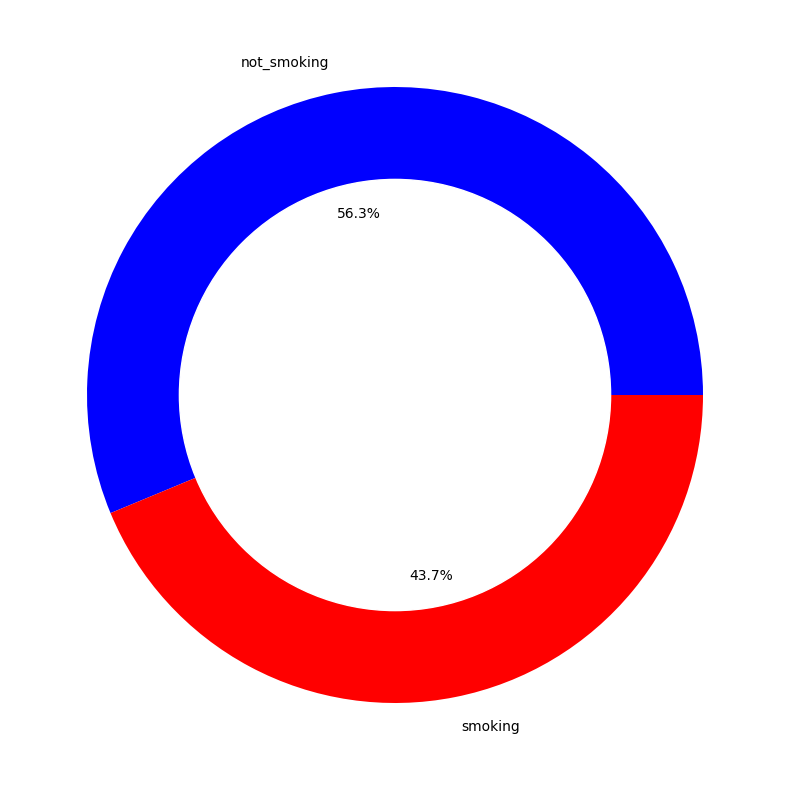

In [10]:
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(train["smoking"].value_counts(), labels=['not_smoking', 'smoking'], colors=['blue','red'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [11]:
categorical_col= ['Urine protein','dental caries','hearing(left)','hearing(right)']

In [12]:
train.columns

Index(['id', 'age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
       'ALT', 'Gtp', 'dental caries', 'smoking'],
      dtype='object')

In [13]:
#Description of Numerical data
train.drop(['smoking','id'],axis=1).drop( categorical_col ,axis = 1).describe().T.style.background_gradient(axis=0)

,count,mean,std,min,25%,50%,75%,max
age,159256.000000,44.306626,11.842286,20.000000,40.000000,40.000000,55.000000,85.000000
height(cm),159256.000000,165.266929,8.818970,135.000000,160.000000,165.000000,170.000000,190.000000
weight(kg),159256.000000,67.143662,12.586198,30.000000,60.000000,65.000000,75.000000,130.000000
waist(cm),159256.000000,83.001990,8.957937,51.000000,77.000000,83.000000,89.000000,127.000000
eyesight(left),159256.000000,1.005798,0.402113,0.100000,0.800000,1.000000,1.200000,9.900000
eyesight(right),159256.000000,1.000989,0.392299,0.100000,0.800000,1.000000,1.200000,9.900000
systolic,159256.000000,122.503648,12.729315,77.000000,114.000000,121.000000,130.000000,213.000000
relaxation,159256.000000,76.874071,8.994642,44.000000,70.000000,78.000000,82.000000,133.000000
fasting blood sugar,159256.000000,98.352552,15.329740,46.000000,90.000000,96.000000,103.000000,375.000000
Cholesterol,159256.000000,195.796165,28.396959,77.000000,175.000000,196.000000,217.000000,393.000000


In [14]:
#Description of  Categorical data
train.drop('id',axis=1)[categorical_col].astype('object').describe(include = 'object')

,Urine protein,dental caries,hearing(left),hearing(right)
count,159256,159256,159256,159256
unique,6,2,2,2
top,1,0,1,1
freq,150862,127724,155438,155526


Remove outliers from numerical data to ensure that values are within a reasonable range :

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23]),
 [Text(1, 0, 'age'),
  Text(2, 0, 'height(cm)'),
  Text(3, 0, 'weight(kg)'),
  Text(4, 0, 'waist(cm)'),
  Text(5, 0, 'eyesight(left)'),
  Text(6, 0, 'eyesight(right)'),
  Text(7, 0, 'hearing(left)'),
  Text(8, 0, 'hearing(right)'),
  Text(9, 0, 'systolic'),
  Text(10, 0, 'relaxation'),
  Text(11, 0, 'fasting blood sugar'),
  Text(12, 0, 'Cholesterol'),
  Text(13, 0, 'triglyceride'),
  Text(14, 0, 'HDL'),
  Text(15, 0, 'LDL'),
  Text(16, 0, 'hemoglobin'),
  Text(17, 0, 'Urine protein'),
  Text(18, 0, 'serum creatinine'),
  Text(19, 0, 'AST'),
  Text(20, 0, 'ALT'),
  Text(21, 0, 'Gtp'),
  Text(22, 0, 'dental caries'),
  Text(23, 0, 'smoking')])

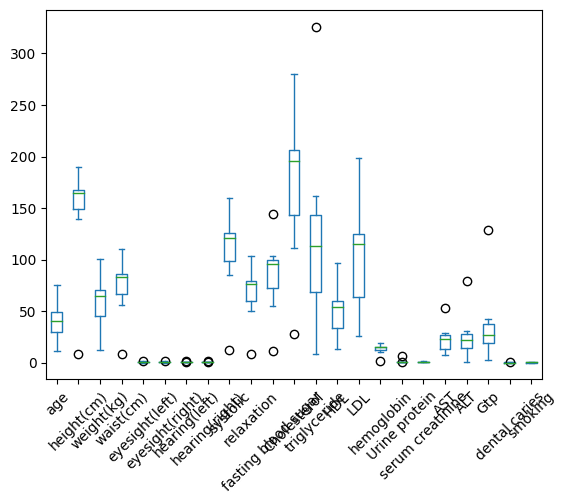

In [15]:
# Remove outliers beyond three standard deviations.
train_without_outlier = train[(np.abs(stats.zscore(train.drop(categorical_col,axis=1).drop(['id'],axis=1))) < 3).all(axis=1)] 
# ( < 3).all(axis=1) checks if, for each row, all column values are within 3 standard deviations from the mean

train_without_outlier.drop(['id'],axis=1).describe().drop('count', axis=0).plot(kind='box')
plt.xticks(rotation=45)

In [16]:
for i in categorical_col:
    chi_squared_test(df=train, input_var=i, target_var='smoking')

Urine protein has a significant relationship with the target.
dental caries has a significant relationship with the target.
hearing(left) has a significant relationship with the target.
hearing(right) has a significant relationship with the target.


Select the top 10 features most correlated with 'smoking,' and arrange them in descending order based on the absolute values of their correlation coefficients :

In [17]:
# 計算與smoking的相關性，由大到小排列
new_corr = train_without_outlier.drop(['id'],axis=1).corr()

new_top_corrs = abs(new_corr["smoking"]).sort_values(ascending = False) 
print(new_top_corrs)

smoking                1.000000
hemoglobin             0.452721
height(cm)             0.445105
Gtp                    0.363032
weight(kg)             0.349882
triglyceride           0.326279
serum creatinine       0.284934
HDL                    0.272093
waist(cm)              0.255358
age                    0.204990
ALT                    0.184977
eyesight(right)        0.143204
eyesight(left)         0.134352
dental caries          0.107015
relaxation             0.100707
fasting blood sugar    0.094245
LDL                    0.082174
Cholesterol            0.066148
systolic               0.052817
AST                    0.041106
hearing(left)          0.034013
hearing(right)         0.033000
Urine protein          0.031273
Name: smoking, dtype: float64


Plot a heatmap of the top 10 features most correlated with 'smoking':

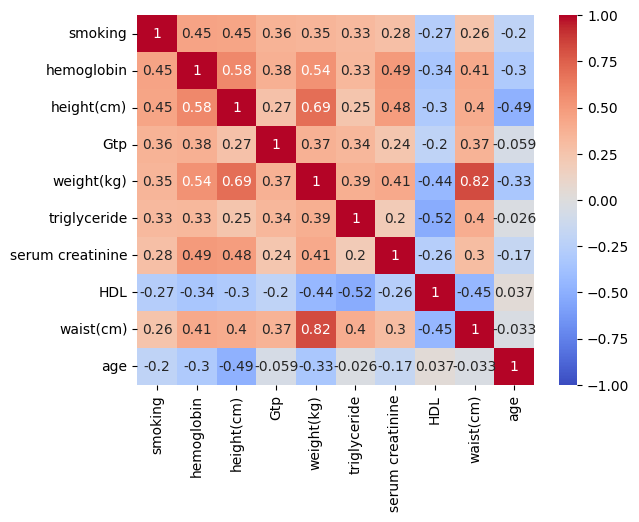

In [18]:
N = 10
#display(new_corr[list(new_top_corrs.head(N).index)].loc[list(new_top_corrs.head(N).index)]) #.iloc[:N,:])
most_important_feature = list(new_top_corrs.head(N).index)
#prit(most_important_feature)
sns.heatmap(new_corr[new_top_corrs.head(N).index].loc[new_top_corrs.head(N).index] , vmin=-1, vmax=1, center=0, square=False, annot=True, cmap='coolwarm') # 你可以再加上annot = True，這樣corr value就可以被畫出來。

plt.show()

Extract features by using domain knowledge and combine train and test data, perform feature extraction, and one-hot encoding: 

In [19]:
merged_df = pd.concat([train_without_outlier, test], axis=0)

# Use "apply" function to add new features
merged_df['BMI'] = merged_df['weight(kg)'] / ((merged_df['height(cm)'] / 100) ** 2)
merged_df['BMI_Category'] = merged_df['BMI'].apply(classify_bmi)
merged_df['health_risk'] = merged_df['age'].apply(classify_age)
merged_df['classify_blood_pressure'] = merged_df.apply(lambda x: classify_blood_pressure(x.systolic, x.relaxation), axis=1)
merged_df['classify_total_HDL_LDL'] = merged_df.apply(lambda x: classify_total_HDL_LDL(x.HDL, x.LDL), axis=1)
merged_df['classify_HDL'] = merged_df['HDL'].apply(classify_HDL)
merged_df['classify_LDL'] = merged_df['LDL'].apply(classify_LDL)
merged_df['classify_triglyceride'] = merged_df['triglyceride'].apply(classify_triglyceride)
merged_df['classify_hemoglobin'] = merged_df['hemoglobin'].apply(classify_hemoglobin)
merged_df['classify_serum_creatinine'] = merged_df['serum creatinine'].apply(classify_serum_creatinine)
merged_df['classify_Gtp'] = merged_df['Gtp'].apply(classify_Gtp)
merged_df['classify_AST'] = merged_df['AST'].apply(classify_AST_ALT_levels)
merged_df['classify_ALT'] = merged_df['ALT'].apply(classify_AST_ALT_levels)

# Add new feature in categorical features list
categorical_col = categorical_col + ['BMI_Category', 'health_risk', 'classify_blood_pressure', 'classify_total_HDL_LDL', 'classify_HDL', 'classify_LDL', 'classify_triglyceride', 'classify_hemoglobin', 'classify_serum_creatinine', 'classify_Gtp', 'classify_AST', 'classify_ALT']

# Get featured data set for visualization
featured_train = merged_df.iloc[:len(train_without_outlier)]

# Encoding data
encoded_merged_df = merged_df
for feature in categorical_col:
    encoded_merged_df = pd.get_dummies(encoded_merged_df, columns=[feature])

# 將train_enc 和 test_enc 拆開來
train_enc = encoded_merged_df.iloc[:len(train_without_outlier)]
test_enc = encoded_merged_df.iloc[len(train_without_outlier):]

Histogram of categorical features by group:

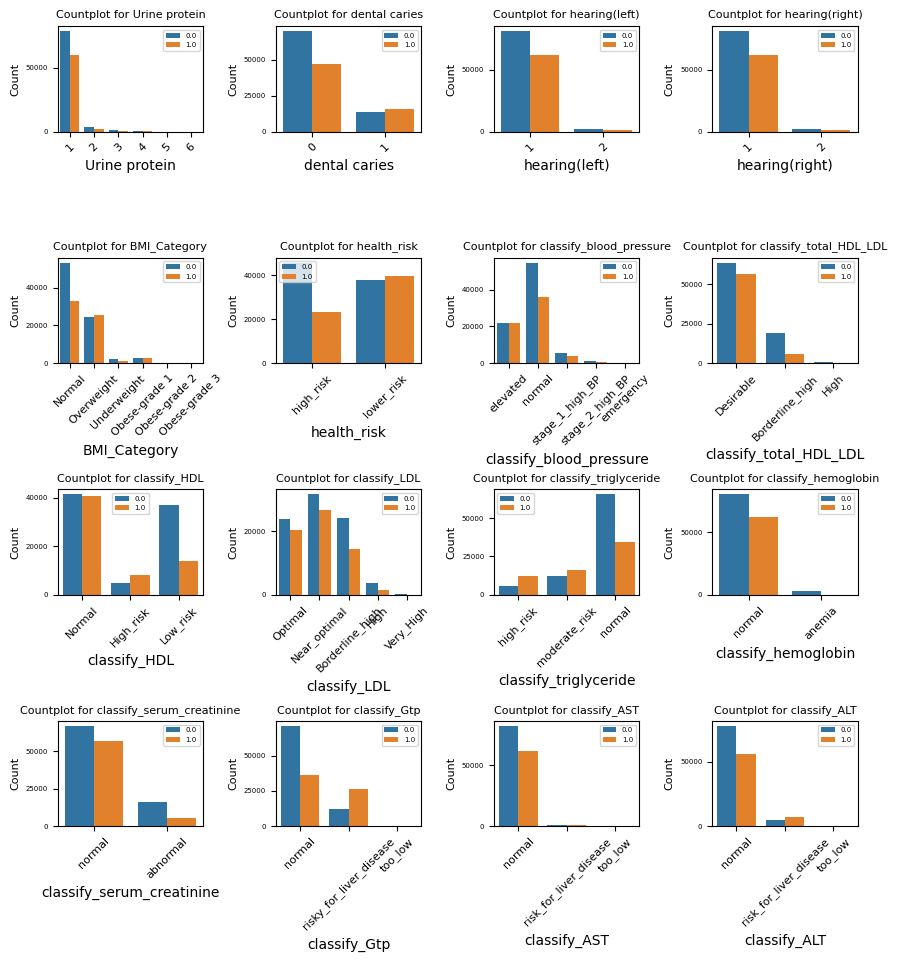

In [20]:
TARGET = 'smoking'            
plot_count(df=featured_train, cat_var=categorical_col, hue=TARGET)

In [21]:
numerical_col = [feat for feat in list(featured_train.columns) if feat not in categorical_col]
numerical_col.remove('id')
numerical_col.remove('smoking')
print("#numerical_col is ",len(numerical_col))
print(numerical_col)

#numerical_col is  19
['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)', 'eyesight(right)', 'systolic', 'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride', 'HDL', 'LDL', 'hemoglobin', 'serum creatinine', 'AST', 'ALT', 'Gtp', 'BMI']


Histogram of numerical features by group :

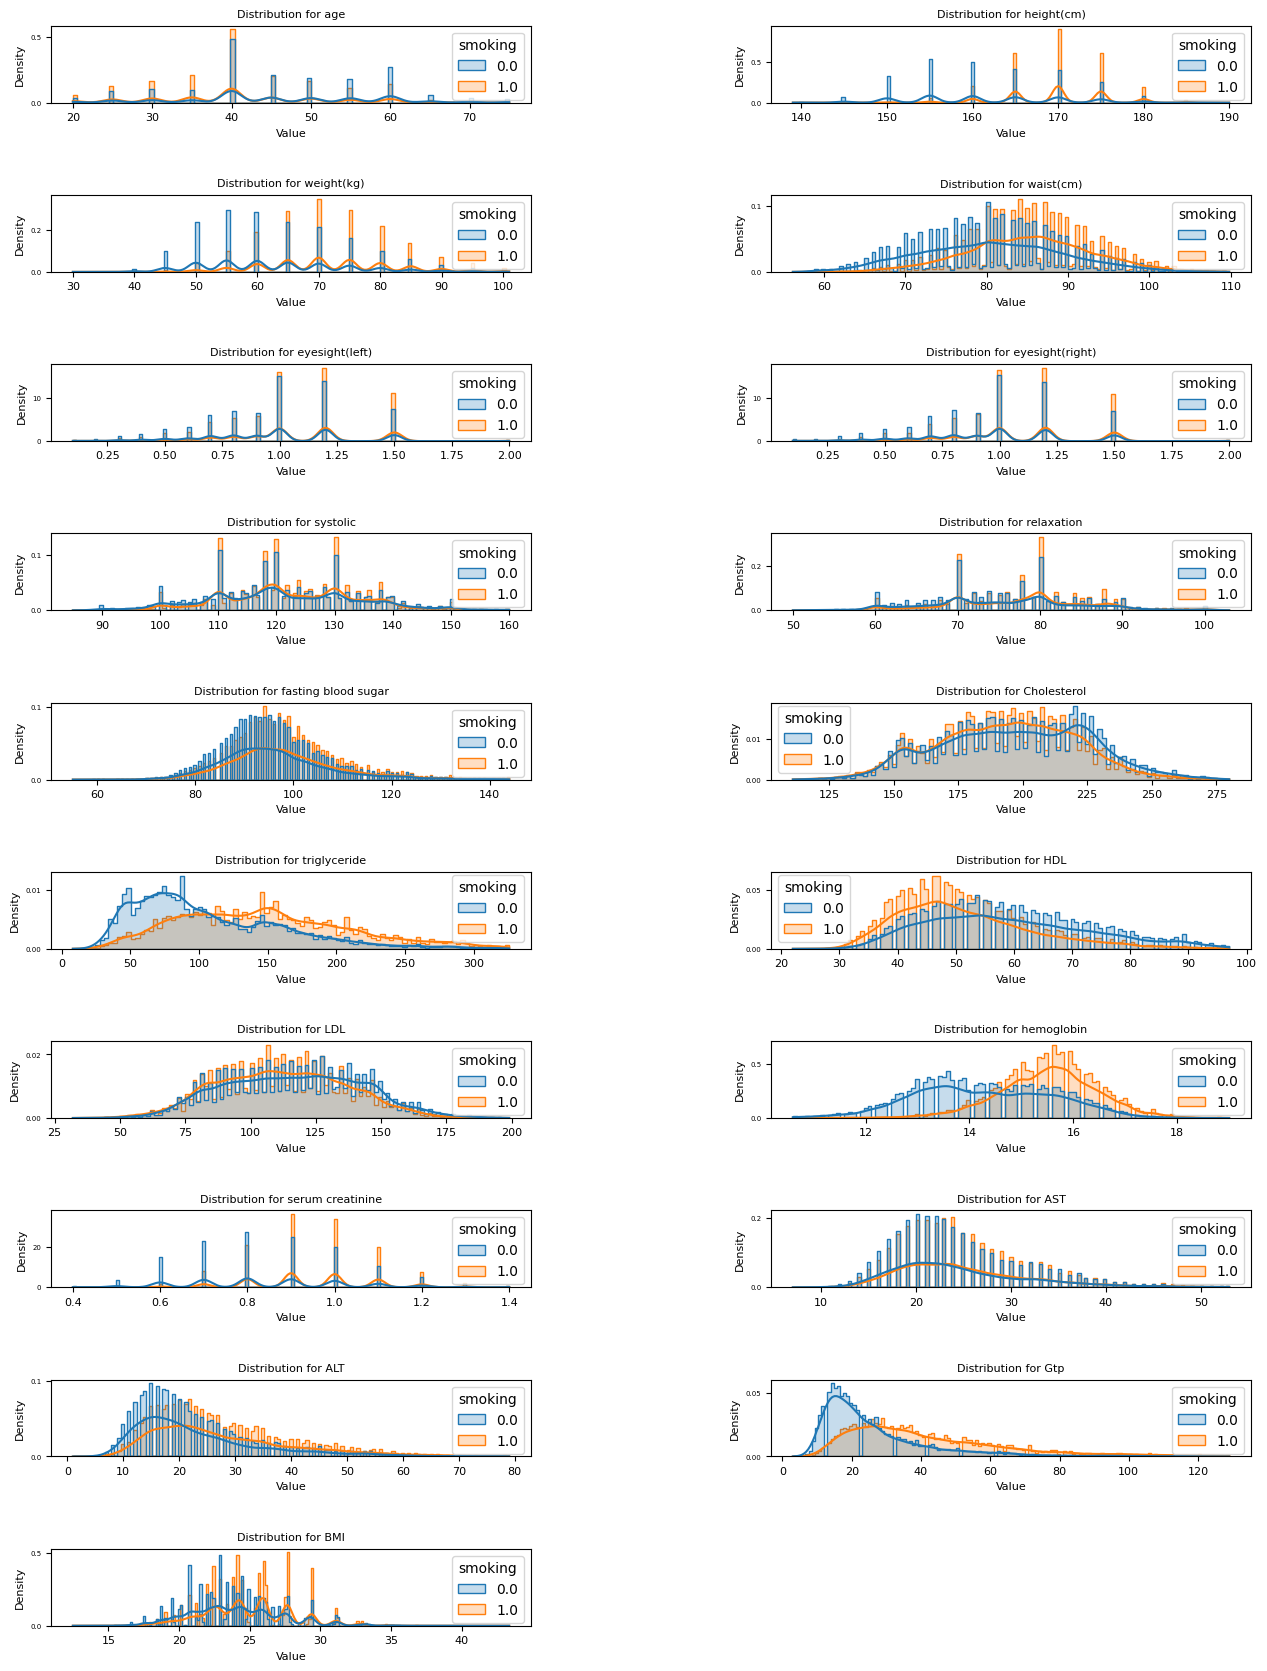

In [22]:
plot_distribution(df=featured_train, num_var=numerical_col, target=TARGET)

In [23]:
df_train,df_val = split_dataframe(df=train_enc)

In [24]:
X_train = df_train.drop(['smoking', 'id'],axis=1)
y_train = df_train['smoking']
X_val = df_val.drop(['smoking','id'],axis=1)
y_val = df_val['smoking']

# Modeling : XGBoost

In [25]:
!pip install xgboost

In [26]:
from xgboost import XGBClassifier

In [27]:
eval_set = [(X_val,y_val)]
# tree_method = 'gpu_hist'
xgbc = XGBClassifier(eval_metric='auc', learning_rate= 0.1, max_depth=6, min_child_weight=2)

In [28]:
# eval_metric="auc"
xgbc.fit(X_train, y_train, eval_set=eval_set, verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

The top 20 most important features in XGBoost, as determined by the dominant node split.

Text(0.5, 1.0, 'Feature Importance')

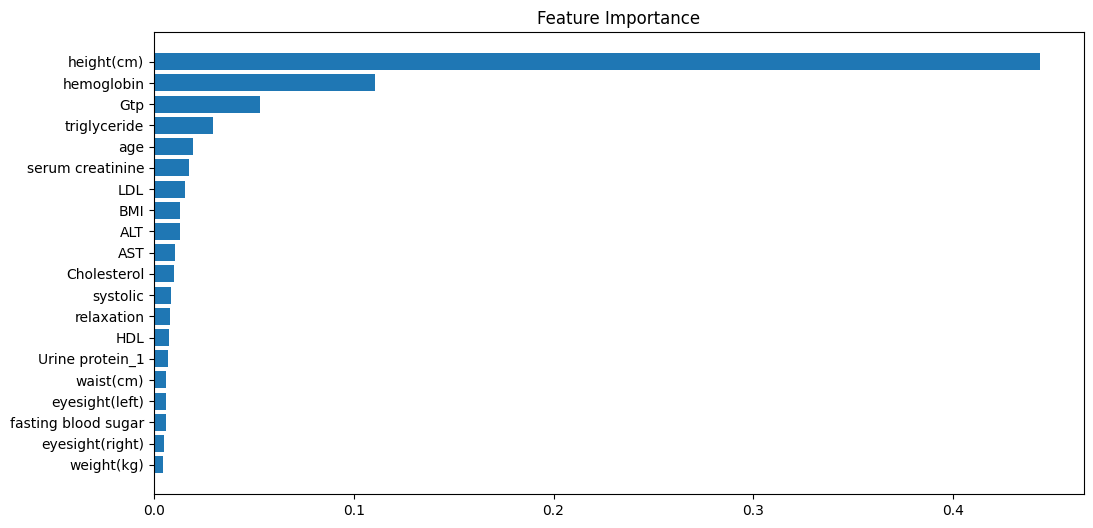

In [29]:
feature_importance = xgbc.feature_importances_[:20]
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_val.columns)[sorted_idx])
plt.title('Feature Importance')

In [30]:

# 預測概率分數
y_pred_prob = xgbc.predict_proba(X_val)[:, 1]
print(y_pred_prob)
# 計算AUC
auc = roc_auc_score(y_val, y_pred_prob)

print("AUC:", auc)
print("Accuracy:", xgbc.score(X_val, y_val))

[0.56860834 0.02477009 0.64460063 ... 0.40559915 0.01634889 0.5537612 ]
AUC: 0.8662537938295202
Accuracy: 0.7798108552631579


Confusion matrix, without normalization
[[6279 2075]
 [1138 5100]]
Normalized confusion matrix
[[0.75161599 0.24838401]
 [0.18243027 0.81756973]]


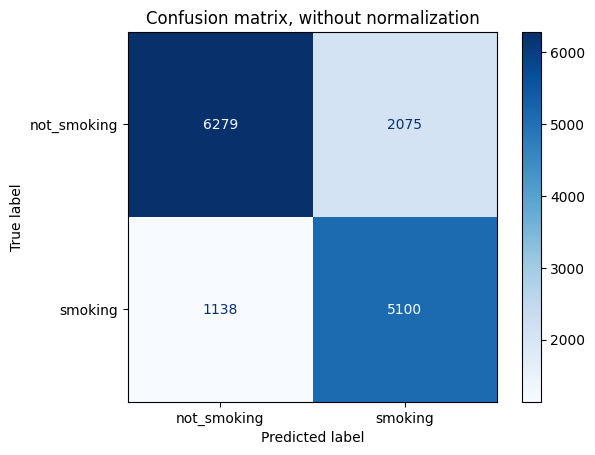

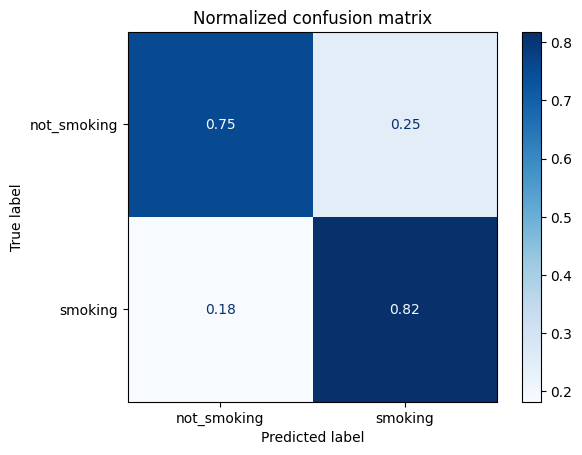

In [31]:
class_names = ['not_smoking', 'smoking'] 


# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        xgbc,
        X_val,
        y_val,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.savefig('xgbc_normalized_confusion.png')    
plt.show()



In [32]:
# xgboost submission
# Because the 'smoking' column contains NaN values, it should be dropped before making predictions.
#xgbc_y_pred = xgbc.predict(test_enc.drop(['id', 'smoking'],axis=1))
xgbc_y_pred = xgbc.predict_proba(test_enc.drop(['id', 'smoking'],axis=1))[:, 1]

prediction = pd.DataFrame(xgbc_y_pred, columns = ['smoking'])

xgbc_submission = pd.concat([test_enc[['id']],prediction],axis=1, ignore_index=False)
display(xgbc_submission)
xgbc_submission.to_csv('/kaggle/working/xgbc_submission.csv',index=False)


,id,smoking
0,159256,0.610186
1,159257,0.312576
2,159258,0.446397
3,159259,0.021268
4,159260,0.588438
...,...,...
106166,265422,0.514849
106167,265423,0.609180
106168,265424,0.470565
106169,265425,0.104879


# Modeling : CatBoost

In [33]:
!pip install catboost

In [34]:
from catboost import CatBoostClassifier

In [35]:
cbc = CatBoostClassifier(task_type="CPU", learning_rate=0.05, depth=6, random_state=42, #iterations=200, 
                         n_estimators= 2048,
                         eval_metric='AUC',
                         use_best_model=True)
history = cbc.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=0, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

The top 20 most important features in CatBoost, as determined by the dominant node split.

Text(0.5, 1.0, 'Feature Importance')

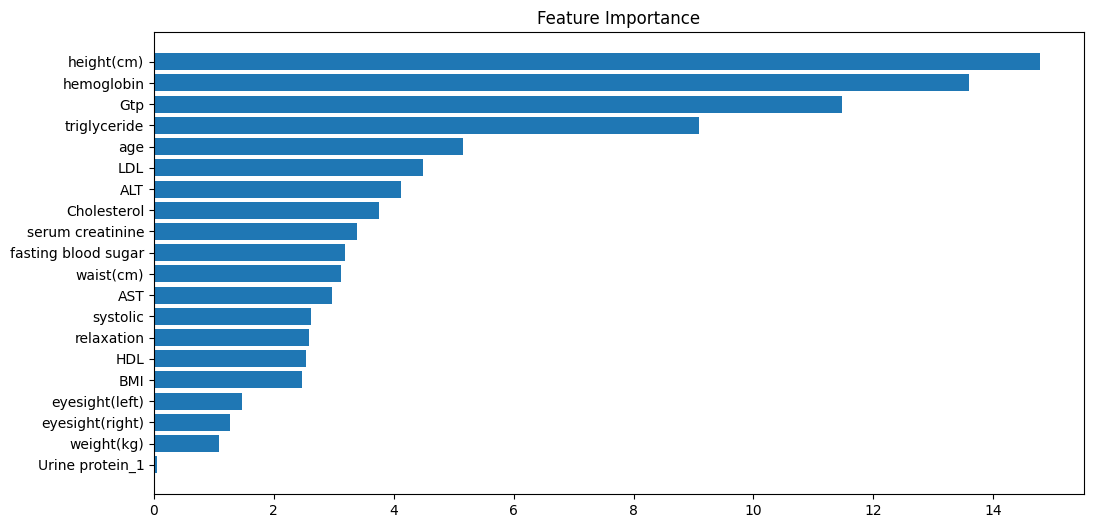

In [36]:
feature_importance = cbc.feature_importances_[:20]
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_val.columns)[sorted_idx])
plt.title('Feature Importance')

In [37]:
# 預測概率分數
y_pred_prob = cbc.predict_proba(X_val)[:, 1]
print(y_pred_prob)
# 計算AUC
auc = roc_auc_score(y_val, y_pred_prob)

print("AUC:", auc)
print("Accuracy:", xgbc.score(X_val, y_val))

[0.51311318 0.03028922 0.68199424 ... 0.54369569 0.00743219 0.64609511]
AUC: 0.8727235007997736
Accuracy: 0.7798108552631579


Confusion matrix, without normalization
[[6441 1913]
 [1141 5097]]
Normalized confusion matrix
[[0.7710079  0.2289921 ]
 [0.18291119 0.81708881]]


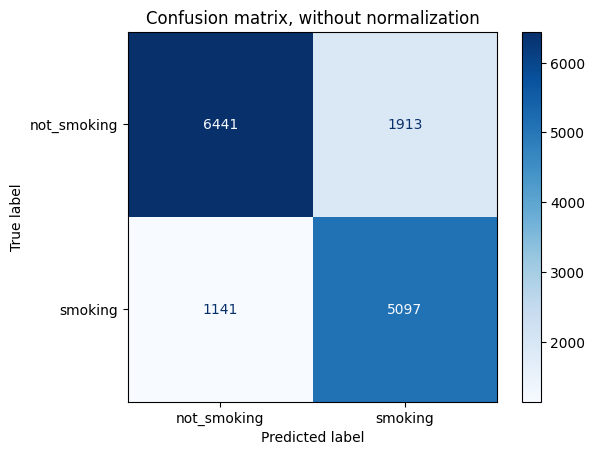

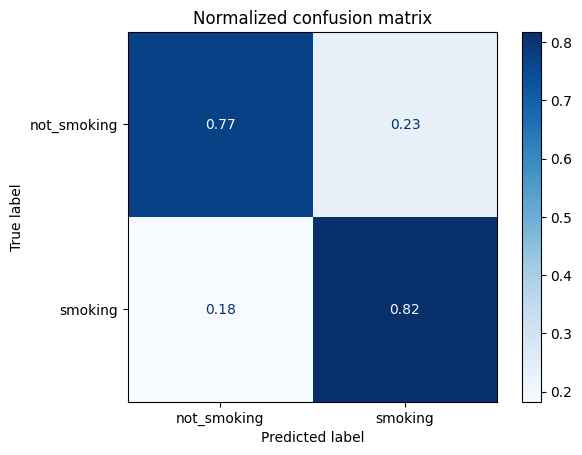

In [38]:
class_names = ['not_smoking', 'smoking'] 


# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        cbc,
        X_val,
        y_val,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.savefig('cbc_normalized_confusion.png')    
plt.show()


In [39]:
# catboost submission
# Because the 'smoking' column contains NaN values, it should be dropped before making predictions.
cbc_y_pred = cbc.predict_proba(test_enc.drop(['id', 'smoking'],axis=1))[:, 1]

prediction = pd.DataFrame(cbc_y_pred, columns = ['smoking'])

cbc_submission = pd.concat([test_enc[['id']],prediction],axis=1, ignore_index=False)
display(cbc_submission)
cbc_submission.to_csv('/kaggle/working/cbc_submission.csv',index=False)

,id,smoking
0,159256,0.529212
1,159257,0.403648
2,159258,0.471674
3,159259,0.017369
4,159260,0.652395
...,...,...
106166,265422,0.617195
106167,265423,0.529441
106168,265424,0.447338
106169,265425,0.088753


# Modeling : lishtbgm

In [40]:
! pip install lightgbm

In [41]:
import lightgbm as lgb

In [42]:
lgbc = lgb.LGBMClassifier(device = "cpu",learning_rate=0.05, max_depth=6,
                         n_estimators= 2048, metric = 'auc')
lgbc.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=0)



/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


LGBMClassifier(device='cpu', learning_rate=0.05, max_depth=6, metric='auc',
               n_estimators=2048)

Text(0.5, 1.0, 'Feature Importance')

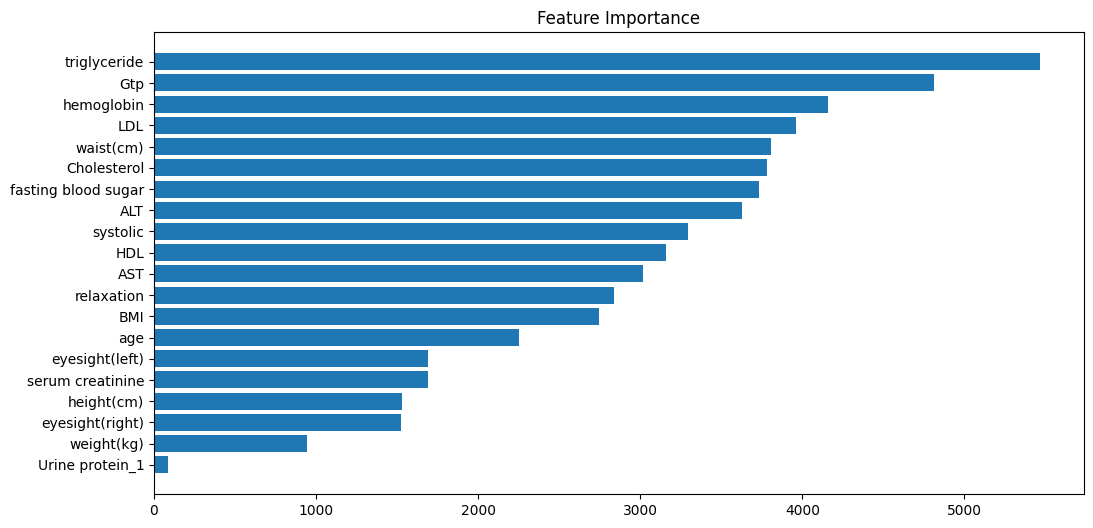

In [43]:
feature_importance = lgbc.feature_importances_[:20]
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_val.columns)[sorted_idx])
plt.title('Feature Importance')

In [44]:
# 預測概率分數
y_pred_prob = lgbc.predict_proba(X_val)[:, 1]
print(y_pred_prob)
# 計算AUC
auc = roc_auc_score(y_val, y_pred_prob)

print("AUC:", auc)
print("Accuracy:", lgbc.score(X_val, y_val))

[0.52369097 0.02534033 0.67002095 ... 0.640039   0.02040497 0.7945606 ]
AUC: 0.8711345270590111
Accuracy: 0.7870065789473685


Confusion matrix, without normalization
[[6430 1924]
 [1184 5054]]
Normalized confusion matrix
[[0.76969117 0.23030883]
 [0.18980442 0.81019558]]


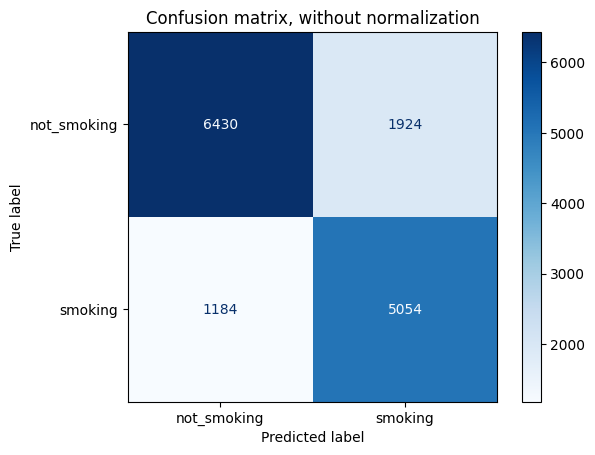

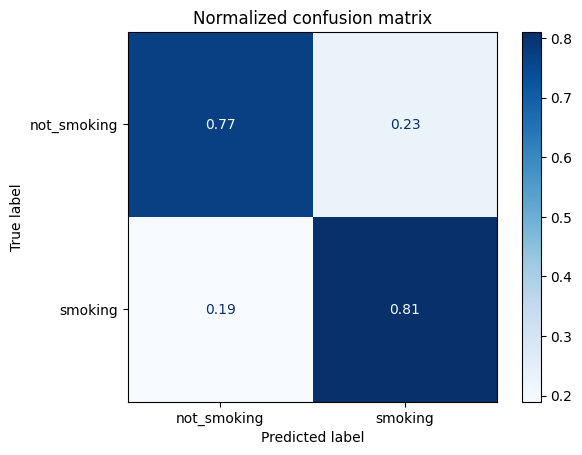

In [45]:
class_names = ['not_smoking', 'smoking'] 


# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        lgbc,
        X_val,
        y_val,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.savefig('lgbc_normalized_confusion.png')    
plt.show()


In [46]:
# lightgbm
# Because the 'smoking' column contains NaN values, it should be dropped before making predictions.
lgbc_y_pred = lgbc.predict_proba(test_enc.drop(['id', 'smoking'],axis=1))[:, 1]

prediction = pd.DataFrame(lgbc_y_pred, columns = ['smoking'])

lgbc_submission = pd.concat([test_enc[['id']],prediction],axis=1, ignore_index=False)
display(lgbc_submission)
lgbc_submission.to_csv('/kaggle/working/lgbc_submission.csv',index=False)

,id,smoking
0,159256,0.606477
1,159257,0.561657
2,159258,0.520808
3,159259,0.013022
4,159260,0.584036
...,...,...
106166,265422,0.689968
106167,265423,0.532717
106168,265424,0.410820
106169,265425,0.066292


# Modeling : DNN (Tensorflow)

In [47]:
import tensorflow as tf

In [48]:
# Ref : https://www.kaggle.com/code/enricomanosperti/binary-prediction-of-smoker-status-using-bio-signa#Train/test-split
def create_dnn_model():
    dnn_model = tf.keras.models.Sequential([
        tf.keras.layers.BatchNormalization(input_shape=(X_train.shape[1], )),
         tf.keras.layers.Dropout(0.3),
         tf.keras.layers.Dense(24, activation='relu',  kernel_initializer='he_uniform'),
         tf.keras.layers.Dense(16, activation='relu',  kernel_initializer='he_uniform'),
         tf.keras.layers.Dense(8, activation='relu',  kernel_initializer='he_uniform'),
         tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    dnn_model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-5),
                   loss=tf.keras.losses.BinaryCrossentropy(),
                   metrics=['accuracy',tf.keras.metrics.AUC(curve='ROC',from_logits=False
)])
    return dnn_model

In [49]:
dnn = create_dnn_model()
history = dnn.fit(X_train.astype(float), y_train, validation_data=(X_val.astype(float), y_val), epochs=15, batch_size=32)

Epoch 1/15
4105/4105 [==============================] - 12s 2ms/step - loss: 0.5141 - accuracy: 0.7301 - auc: 0.8098 - val_loss: 0.4732 - val_accuracy: 0.7579 - val_auc: 0.8441
Epoch 2/15
4105/4105 [==============================] - 9s 2ms/step - loss: 0.4968 - accuracy: 0.7447 - auc: 0.8247 - val_loss: 0.4663 - val_accuracy: 0.7616 - val_auc: 0.8480
Epoch 3/15
4105/4105 [==============================] - 9s 2ms/step - loss: 0.4940 - accuracy: 0.7453 - auc: 0.8269 - val_loss: 0.4630 - val_accuracy: 0.7687 - val_auc: 0.8509
Epoch 4/15
4105/4105 [==============================] - 9s 2ms/step - loss: 0.4925 - accuracy: 0.7466 - auc: 0.8277 - val_loss: 0.4629 - val_accuracy: 0.7680 - val_auc: 0.8508
Epoch 5/15
4105/4105 [==============================] - 9s 2ms/step - loss: 0.4908 - accuracy: 0.7483 - auc: 0.8294 - val_loss: 0.4625 - val_accuracy: 0.7676 - val_auc: 0.8512
Epoch 6/15
4105/4105 [==============================] - 9s 2ms/step - loss: 0.4912 - accuracy: 0.7489 - auc: 0.8293 - v

In [50]:
predicted_probabilities = dnn.predict(X_val.astype(float))
predicted_probabilities = np.squeeze(predicted_probabilities)
print(predicted_probabilities)
roc_auc_score(y_val, predicted_probabilities)

456/456 [==============================] - 1s 1ms/step
[0.5804033  0.02881821 0.7824964  ... 0.3524748  0.00802908 0.5077499 ]


0.8515366309634824

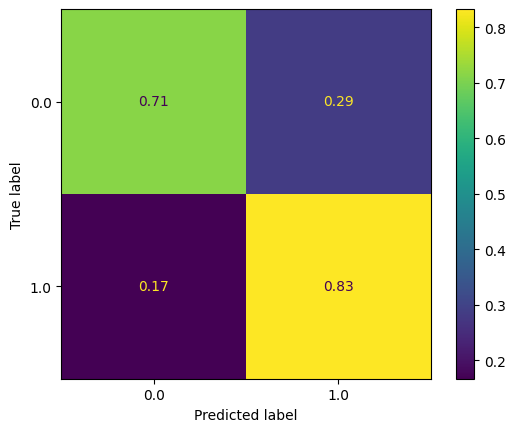

In [51]:
from sklearn.metrics import ConfusionMatrixDisplay

class_names = ['not_smoking', 'smoking'] 

class estimator:
# ref : https://www.kaggle.com/code/mdmashurshalehin/plotting-confusion-matrix-for-tensorflow-model    
    _estimator_type = ''
    classes_=[]
    def __init__(self, model, classes):
        self.model = model
        self._estimator_type = 'classifier'
        self.classes_ = classes
    def predict(self, X):
        y_prob= self.model.predict(X)
        y_pred = y_prob.argmax(axis=1)
        return y_pred

classifier = estimator(dnn, class_names)



predict_one_zero = np.array([1 if x > 0.5 else 0 for x in list(predicted_probabilities)])
ConfusionMatrixDisplay.from_predictions(y_val, predict_one_zero, normalize='true')

plt.savefig('dnn_normalized_confusion.png')   



In [52]:
# dnn submission
# Because the 'smoking' column contains NaN values, it should be dropped before making predictions.
dnn_y_pred = dnn.predict(test_enc.drop(['id', 'smoking'],axis=1).astype(float)) #[:, 1]
dnn_y_pred = np.squeeze(dnn_y_pred)
#print(dnn_y_pred)

prediction = pd.DataFrame(cbc_y_pred, columns = ['smoking'])
#print(prediction)

dnn_submission = pd.concat([test_enc[['id']],prediction],axis=1, ignore_index=False)
display(dnn_submission)
dnn_submission.to_csv('/kaggle/working/dnn_submission.csv',index=False)


3318/3318 [==============================] - 4s 1ms/step


,id,smoking
0,159256,0.529212
1,159257,0.403648
2,159258,0.471674
3,159259,0.017369
4,159260,0.652395
...,...,...
106166,265422,0.617195
106167,265423,0.529441
106168,265424,0.447338
106169,265425,0.088753


**Ensemble learning : Averaging method**

In [53]:
#cbc_submission xgbc_submission lgbc_submission dnn_submission

total_pred = pd.concat([cbc_submission['id'], cbc_submission['smoking'], xgbc_submission['smoking'], lgbc_submission['smoking'], dnn_submission['smoking']],axis=1, keys= ['id', 'cbc_smoking', 'xgbc_smoking', 'lgbc_smoking', 'dnn_smoking']) #, ignore_index=False)
display(total_pred)

,id,cbc_smoking,xgbc_smoking,lgbc_smoking,dnn_smoking
0,159256,0.529212,0.610186,0.606477,0.529212
1,159257,0.403648,0.312576,0.561657,0.403648
2,159258,0.471674,0.446397,0.520808,0.471674
3,159259,0.017369,0.021268,0.013022,0.017369
4,159260,0.652395,0.588438,0.584036,0.652395
...,...,...,...,...,...
106166,265422,0.617195,0.514849,0.689968,0.617195
106167,265423,0.529441,0.609180,0.532717,0.529441
106168,265424,0.447338,0.470565,0.410820,0.447338
106169,265425,0.088753,0.104879,0.066292,0.088753


In [54]:
total_pred['average_pred'] = total_pred.apply(lambda x: 0.25*(x.dnn_smoking + x.cbc_smoking + x.xgbc_smoking + x.lgbc_smoking ), axis=1)

In [55]:
ave_submission = total_pred[['id', 'average_pred']].rename({'average_pred': 'smoking'}, axis=1)
ave_submission.to_csv('/kaggle/working/ave_submission.csv',index=False)
display(ave_submission)

,id,smoking
0,159256,0.568772
1,159257,0.420383
2,159258,0.477638
3,159259,0.017257
4,159260,0.619316
...,...,...
106166,265422,0.609802
106167,265423,0.550195
106168,265424,0.444015
106169,265425,0.087169


# Ensemble learning : Voting method (only tree based)

In [56]:
import sklearn 
from sklearn.ensemble import VotingClassifier

In [57]:
# Voting of 3 tree-based models
xgbc = XGBClassifier( eval_metric='auc', learning_rate= 0.1, max_depth=7, min_child_weight=2)

cbc = CatBoostClassifier(learning_rate=0.05, depth=7, random_state=42, #iterations=200, 
                         task_type="CPU", 
                         n_estimators= 2048,
                         eval_metric='AUC',
                         use_best_model=False)

lgbc = lgb.LGBMClassifier(device = "cpu", learning_rate=0.05, max_depth=7,
                         n_estimators= 2048,
                         metric = 'auc')

voting_model = VotingClassifier(verbose=True, estimators=[('cbc', cbc),('xgbc',xgbc), ('lgbc',lgbc)], voting='soft')
voting_model.fit(X_train,y_train)

0:	total: 38.1ms	remaining: 1m 17s
1:	total: 72.7ms	remaining: 1m 14s
2:	total: 111ms	remaining: 1m 15s
3:	total: 147ms	remaining: 1m 14s
4:	total: 185ms	remaining: 1m 15s
5:	total: 220ms	remaining: 1m 14s
6:	total: 258ms	remaining: 1m 15s
7:	total: 291ms	remaining: 1m 14s
8:	total: 326ms	remaining: 1m 13s
9:	total: 360ms	remaining: 1m 13s
10:	total: 394ms	remaining: 1m 13s
11:	total: 429ms	remaining: 1m 12s
12:	total: 464ms	remaining: 1m 12s
13:	total: 502ms	remaining: 1m 12s
14:	total: 535ms	remaining: 1m 12s
15:	total: 569ms	remaining: 1m 12s
16:	total: 602ms	remaining: 1m 11s
17:	total: 635ms	remaining: 1m 11s
18:	total: 670ms	remaining: 1m 11s
19:	total: 707ms	remaining: 1m 11s
20:	total: 743ms	remaining: 1m 11s
21:	total: 776ms	remaining: 1m 11s
22:	total: 808ms	remaining: 1m 11s
23:	total: 842ms	remaining: 1m 11s
24:	total: 874ms	remaining: 1m 10s
25:	total: 913ms	remaining: 1m 11s
26:	total: 949ms	remaining: 1m 11s
27:	total: 986ms	remaining: 1m 11s
28:	total: 1.02s	remaining: 

VotingClassifier(estimators=[('cbc',
                              <catboost.core.CatBoostClassifier object at 0x7c05142dabc0>),
                             ('xgbc',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='auc',
                                            feature_types=None, gamma=None,
                                            gpu_id=None, grow_policy...
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None, min_child_weight=2,
                                            missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...)),
                             ('lgbc',
                              LGBMClassifier(device='cpu', learning_rate=0.05,
                                             max_depth=7, metric='auc',
                                             n_estimators=2048))],
                 verbose=True, voting='soft')

In [58]:
voting_predicted_probabilities = voting_model.predict_proba(X_val.astype(float))[:, 1]
#voting_predicted_probabilities = np.squeeze(voting_predicted_probabilities)
print(voting_predicted_probabilities)
roc_auc_score(y_val, voting_predicted_probabilities)

[0.53066566 0.02215572 0.64905403 ... 0.47689712 0.01059422 0.69306383]


0.8721502191077829

Confusion matrix, without normalization
[[6394 1960]
 [1153 5085]]
Normalized confusion matrix
[[0.76538185 0.23461815]
 [0.18483488 0.81516512]]


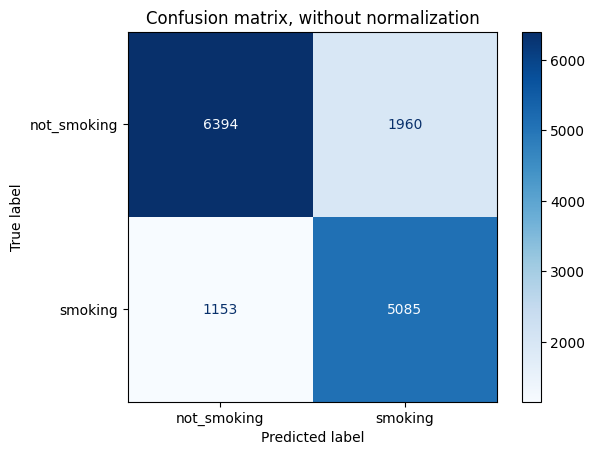

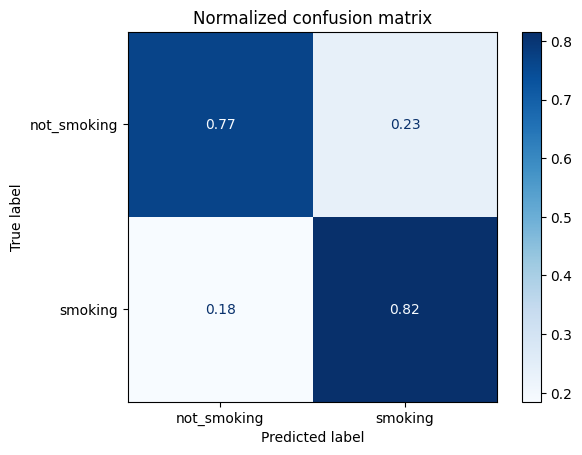

In [66]:
class_names = ['not_smoking', 'smoking'] 


# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        voting_model,
        X_val,
        y_val,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.savefig('voting_model_normalized_confusion.png')    
plt.show()


In [59]:
# voting classifier
# Because the 'smoking' column contains NaN values, it should be dropped before making predictions.
voting_y_pred = voting_model.predict_proba(test_enc.drop(['id', 'smoking'],axis=1))[:, 1]

prediction = pd.DataFrame(voting_y_pred, columns = ['smoking'])

voting_submission = pd.concat([test_enc[['id']],prediction],axis=1, ignore_index=False)
display(voting_submission)
voting_submission.to_csv('/kaggle/working/voting_submission.csv',index=False)

,id,smoking
0,159256,0.602224
1,159257,0.370059
2,159258,0.476935
3,159259,0.015541
4,159260,0.594944
...,...,...
106166,265422,0.593596
106167,265423,0.555854
106168,265424,0.439379
106169,265425,0.082952


# Ensemble learning : Voting method (DNN and tree based)

In [60]:
from sklearn.neural_network import MLPClassifier

classifiers = []

mlp = MLPClassifier( random_state=123, verbose=1, batch_size=64, #hidden_layer_sizes=(100,2),
                    #max_iter=20,
                    early_stopping = True,
                   alpha = 10.0 ** -3, 
                    hidden_layer_sizes = (12,3), 
                 learning_rate = 'adaptive',
                 learning_rate_init = 1e-4
                   )
classifiers.append(mlp)

xgbc = XGBClassifier(# tree_method = 'gpu_hist' ,
                     eval_metric='auc',
                    learning_rate = 0.3 , 
                    max_depth = 7,#4, 
                    min_child_weight= 5, 
                    n_estimators = 2048
)

classifiers.append(xgbc)

cbc = CatBoostClassifier(task_type="CPU", 
                         learning_rate=0.05, 
                         depth= 7,#4, 
                         random_state=42, #iterations=200, 
                         n_estimators= 2048,
                         eval_metric='AUC',
                         use_best_model=False)

classifiers.append(cbc)


lgbc = lgb.LGBMClassifier(device = "cpu",
                          learning_rate=0.05, 
                          max_depth= 7,#4,
                          n_estimators= 2048, 
                          metric = 'auc')

classifiers.append(lgbc)

In [61]:
"""
from sklearn.neural_network import MLPClassifier

classifiers = []

mlp = MLPClassifier( random_state=123, verbose=1, batch_size=64, #hidden_layer_sizes=(100,2),
                    #max_iter=20,
                    early_stopping = True)
classifiers.append(mlp)

xgbc = XGBClassifier(# tree_method = 'gpu_hist' ,
                     eval_metric='auc')

classifiers.append(xgbc)

cbc = CatBoostClassifier(random_state=42, #iterations=200, 
                         task_type="CPU", 
                         #n_estimators= 2048,
                         eval_metric='AUC',
                         use_best_model=False)

classifiers.append(cbc)

lgbc = lgb.LGBMClassifier(device = "cpu",random_state=42, learning_rate=0.05, metric = 'auc')

classifiers.append(lgbc)


parameters=[]
parameters_mlp = {'alpha': 10.0 ** -np.arange(1, 4), 
                'hidden_layer_sizes':[(16,2)], 
                 'learning_rate' : ['constant','adaptive'],
                 'learning_rate_init':[1e-3,1e-4,1e-5]}
parameters.append(parameters_mlp)
parameters_xgbc = {  "learning_rate" : [0.1, 0.3, 0.5], "max_depth" : [4], "min_child_weight" : [1,5,15,200], "n_estimators" : [512] }

parameters.append(parameters_xgbc)
parameters_cbc = {"learning_rate" : [0.1, 0.3, 0.5] , "depth" : [4], # "random_state" : 42, #iterations=200,  
                         "n_estimators" : [512]} #"use_best_model" : [False]
parameters.append(parameters_cbc)
parameters_lgbc = { "learning_rate" : [0.1, 0.3, 0.5] , "max_depth" : [4], "n_estimators" : [512]}
parameters.append(parameters_lgbc)

# ref : https://www.kaggle.com/code/maheshas88/titanic-4-classifier-voting-with-gridsearchcv
#Here grid search is performed for each model. THe best estimator combination for each model
#is stored in a list best_models.
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV
def gridSearchCV(models,params,count):
    best_models=[]
    for i in tqdm(range(0,count)): 
        print("model = ",models[i])
        model_grid = GridSearchCV(models[i], parameters[i], n_jobs=-1, verbose=1, cv=5)
        model_grid.fit(X_train,y_train)
        best_models.append(model_grid.best_estimator_)
    return best_models

best_model_list = gridSearchCV(classifiers,parameters,4)
"""

'\nfrom sklearn.neural_network import MLPClassifier\n\nclassifiers = []\n\nmlp = MLPClassifier( random_state=123, verbose=1, batch_size=64, #hidden_layer_sizes=(100,2),\n                    #max_iter=20,\n                    early_stopping = True)\nclassifiers.append(mlp)\n\nxgbc = XGBClassifier(# tree_method = \'gpu_hist\' ,\n                     eval_metric=\'auc\')\n\nclassifiers.append(xgbc)\n\ncbc = CatBoostClassifier(random_state=42, #iterations=200, \n                         task_type="CPU", \n                         #n_estimators= 2048,\n                         eval_metric=\'AUC\',\n                         use_best_model=False)\n\nclassifiers.append(cbc)\n\nlgbc = lgb.LGBMClassifier(device = "cpu",random_state=42, learning_rate=0.05, metric = \'auc\')\n\nclassifiers.append(lgbc)\n\n\nparameters=[]\nparameters_mlp = {\'alpha\': 10.0 ** -np.arange(1, 4), \n                \'hidden_layer_sizes\':[(16,2)], \n                 \'learning_rate\' : [\'constant\',\'adaptive\'],\n   

In [ ]:
vot_clf = VotingClassifier(estimators=[('mlp', classifiers[0]), ('xgbc', classifiers[1]), 
                                       ('cbc', classifiers[2]), ('lgbc', classifiers[3])],
                           voting='soft',n_jobs=-1)

vot_clf.fit(X_train,y_train)

In [63]:
vot_clf_predicted_probabilities = vot_clf.predict_proba(X_val.astype(float))[:, 1]
#voting_predicted_probabilities = np.squeeze(voting_predicted_probabilities)
print(vot_clf_predicted_probabilities)
roc_auc_score(y_val, vot_clf_predicted_probabilities)

[0.44127432 0.02771092 0.74940919 ... 0.48698044 0.00699679 0.70089059]


0.8715765344395403

Confusion matrix, without normalization
[[6460 1894]
 [1234 5004]]
Normalized confusion matrix
[[0.77328226 0.22671774]
 [0.19781981 0.80218019]]


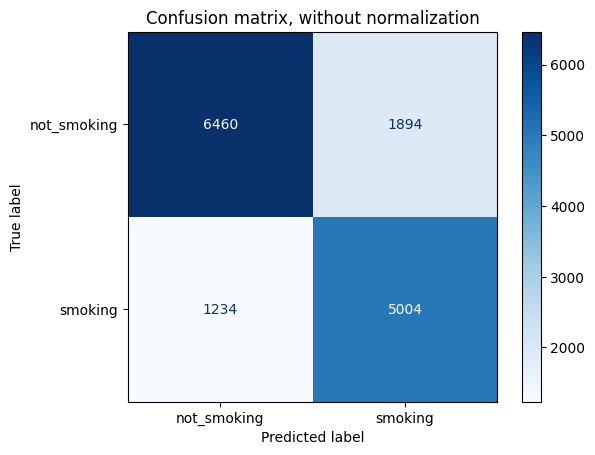

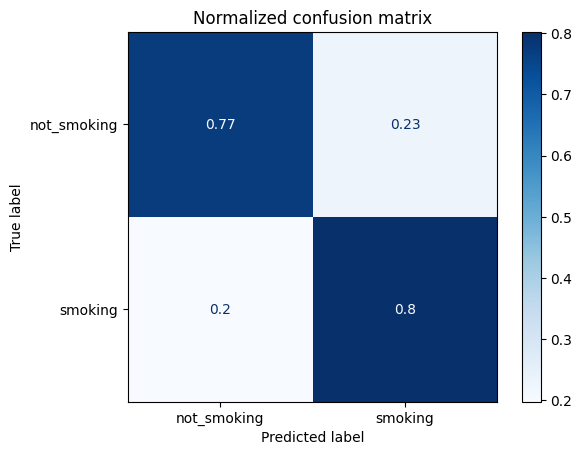

In [65]:
class_names = ['not_smoking', 'smoking'] 


# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        vot_clf,
        X_val,
        y_val,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.savefig('vot_clf_normalized_confusion.png')    
plt.show()


In [64]:
vot_clf_y_pred = vot_clf.predict_proba(test_enc.drop(['id', 'smoking'],axis=1))[:, 1]

prediction = pd.DataFrame(vot_clf_y_pred, columns = ['smoking'])

vot_clf_submission = pd.concat([test_enc[['id']],prediction],axis=1, ignore_index=False)
display(vot_clf_submission)
vot_clf_submission.to_csv('/kaggle/working/vot_clf_submission.csv',index=False)

,id,smoking
0,159256,0.607882
1,159257,0.449917
2,159258,0.472745
3,159259,0.014105
4,159260,0.603363
...,...,...
106166,265422,0.672576
106167,265423,0.566746
106168,265424,0.441438
106169,265425,0.072466


# Summary

The AUC scores of the three tree-based methods show minimal differences when the tree size is kept constant. When utilizing a voting model combining the three, the test set score reaches 87.068%, slightly surpassing the individual scores of each tree-based model (around 86%). Furthermore, incorporating the DNN model into the voting ensemble results in a slightly lower score of 87.054% compared to the tree-based models, accompanied by significantly longer training times (over 10 minutes compared to around 2 minutes).